# TAREA NO. 3 - ESTADÍSTICA MULTIVARIADA: REGRESIÓN MULTIVARIADA

## 1. Contexto de la base de datos
Este conjutno de datos contiene seis meses de datos de consumo eléctrico de un hogar, recogidos entre enero y junio de 2007. Los datos incluyen información sobre potencia activa global, potencia reactiva global, tensión, intensidad global, submedición 1 (cocina), submedición 2 (lavadero) y submedición 3 (calentador de agua eléctrico y aire acondicionado). Con 260.640 mediciones en total, el objetivo es predecir o estimar el consumo eléctrico de los hogares.

| Nombre de la columna | Descripción |
| --- | --- |
| Fecha | La fecha de la observación. (Fecha) |
| Hora | La hora de la observación. (Hora) |
| Potencia_activa_global | La potencia activa total consumida por el hogar (kilovatios). (Numérico) |
| Potencia_reactiva_global | La potencia reactiva total consumida por el hogar (kilovatios). (Numérico) |
| Voltaje | El voltaje al cual se entrega la electricidad al hogar (voltios). (Numérico) |
| Intensidad_global | La intensidad de corriente promedio entregada al hogar (amperios). (Numérico) |
| Sub_medición_1 | La potencia activa consumida por la cocina (kilovatios). (Numérico) |
| Sub_medición_2 | La potencia activa consumida por la lavandería (kilovatios). (Numérico) |
| Sub_medición_3 | La potencia activa consumida por el calentador de agua eléctrico y el aire acondicionado (kilovatios). (Numérico) |

La variable respuesta para el modelo de regresión múltiple es la potencia aparente global en la red. A priori, esta variable no está incluida dentro del conjunto de datos, por lo que es necesario obtenerla a parir de la potencia reactiva y activa global que si están disponibles en el conjunto de datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('household_power_consumption.csv')
df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [3]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df.set_index('Datetime')
df = df.iloc[:, 3:4]
df.head()

C:\Users\kevin\AppData\Local\Temp\ipykernel_11800\747516011.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)


,Global_active_power
Datetime,
2007-01-01 00:00:00,2.58
2007-01-01 00:01:00,2.552
2007-01-01 00:02:00,2.55
2007-01-01 00:03:00,2.55
2007-01-01 00:04:00,2.554


In [4]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

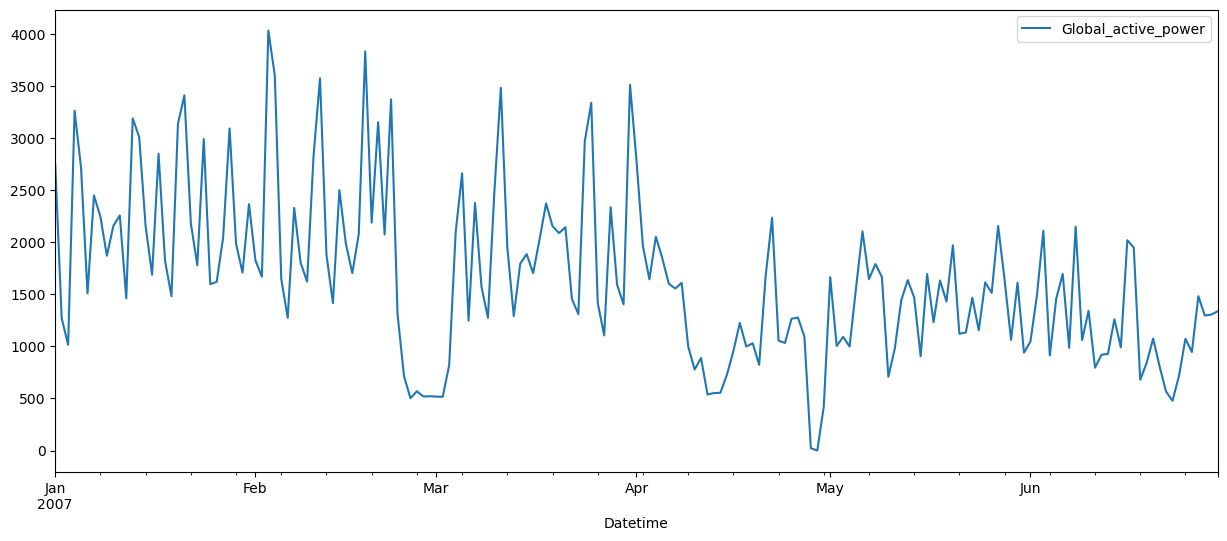

In [5]:
# Resampling data over day
df = df.resample('D').sum()

# Plotting
df.plot(figsize=(15, 6))
plt.show()

In [6]:
df.head()

,Global_active_power
Datetime,
2007-01-01,2749.004
2007-01-02,1269.236
2007-01-03,1014.054
2007-01-04,3259.412
2007-01-05,2713.364


In [7]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller aumentada para estacionariedad
adf_test = adfuller(df, autolag='AIC')

# Extraer resultados
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

# Mostrar resultados
{
    "ADF Statistic": adf_statistic,
    "p-value": p_value,
    "Critical Values": critical_values,
}

{'ADF Statistic': -2.8559989683250664,
 'p-value': 0.050709198028531556,
 'Critical Values': {'1%': -3.4687256239864017,
  '5%': -2.8783961376954363,
  '10%': -2.57575634100705}}

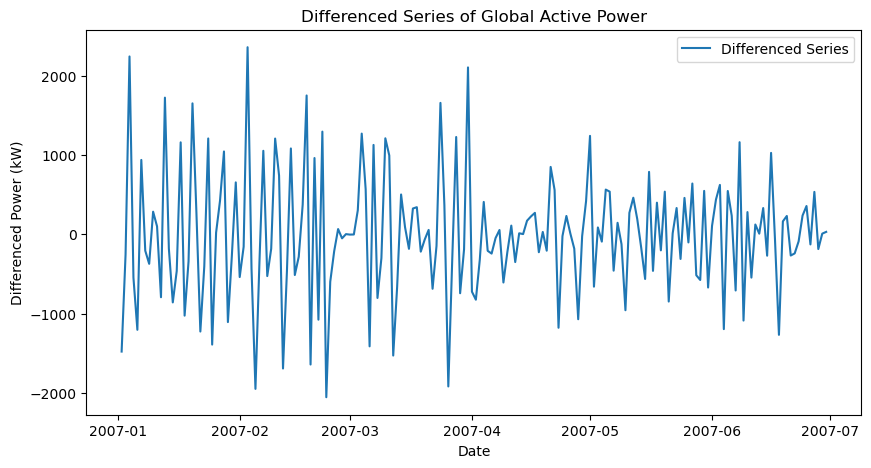

{'ADF Statistic': -6.432525095309374,
 'p-value': 1.6836123429635303e-08,
 'Number of Lags Used': 11,
 'Number of Observations Used': 168,
 'Critical Values': {'1%': -3.4698858990744115,
  '5%': -2.8789026251889647,
  '10%': -2.5760266680839004}}

In [8]:
# Differentiate the series to achieve stationarity (if needed)
data_diff = df.diff().dropna()

# Perform ADF test on the differenced series
result_diff = adfuller(data_diff)

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(data_diff, label='Differenced Series')
plt.title('Differenced Series of Global Active Power')
plt.xlabel('Date')
plt.ylabel('Differenced Power (kW)')
plt.legend()
plt.show()

# Display ADF test results for the differenced series
adf_diff_results = {
    'ADF Statistic': result_diff[0],
    'p-value': result_diff[1],
    'Number of Lags Used': result_diff[2],
    'Number of Observations Used': result_diff[3],
    'Critical Values': result_diff[4]
}
adf_diff_results

El p-valor es extremadamente bajo, lo que significa que ahora podemos rechazar la hipótesis nula (H₀). La serie diferenciada es estacionaria.

In [9]:
train_size = int(len(df) * 0.9)

train = data_diff[:train_size]
test = data_diff[train_size:]

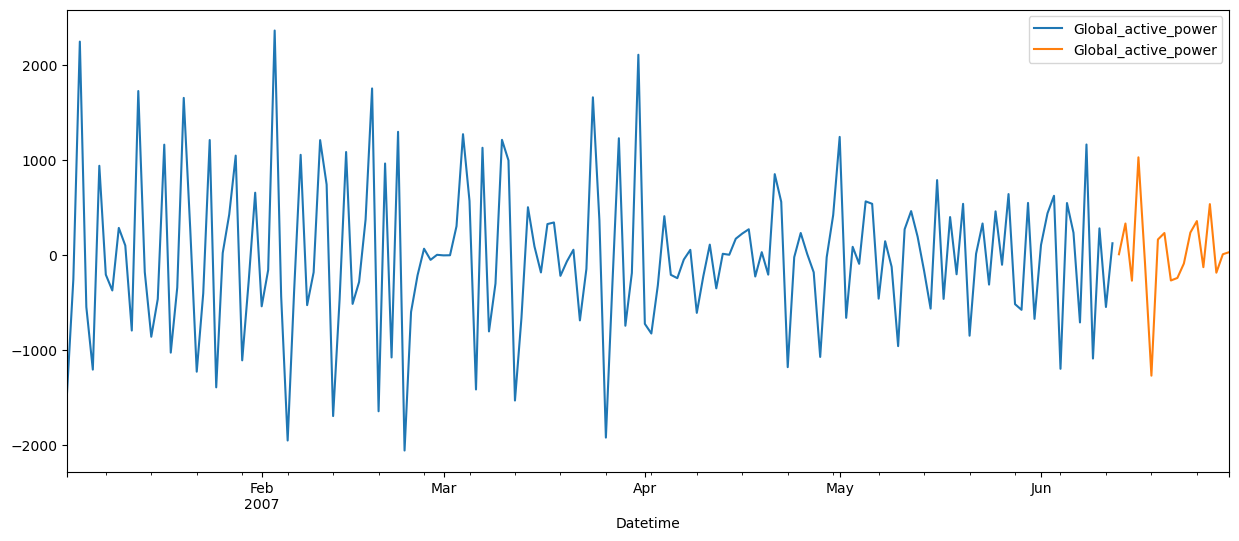

In [10]:
plt.figure(figsize=(15, 6))
train.plot(ax=plt.gca())
test.plot(ax=plt.gca())
plt.legend(loc='best')
plt.show()

In [11]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(
    train,
    seasonal=False,
    stationary=True,
    stepwise=True, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
    max_p=10, max_q=10, max_d=2
)

best_params = auto_arima_model.get_params()
best_params

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2580.813, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2634.393, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2625.029, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2590.618, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2632.425, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2580.894, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2563.899, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=2563.034, Time=0.37 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=2577.292, Time=0.29 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=2556.810, Time=0

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 0, 5),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

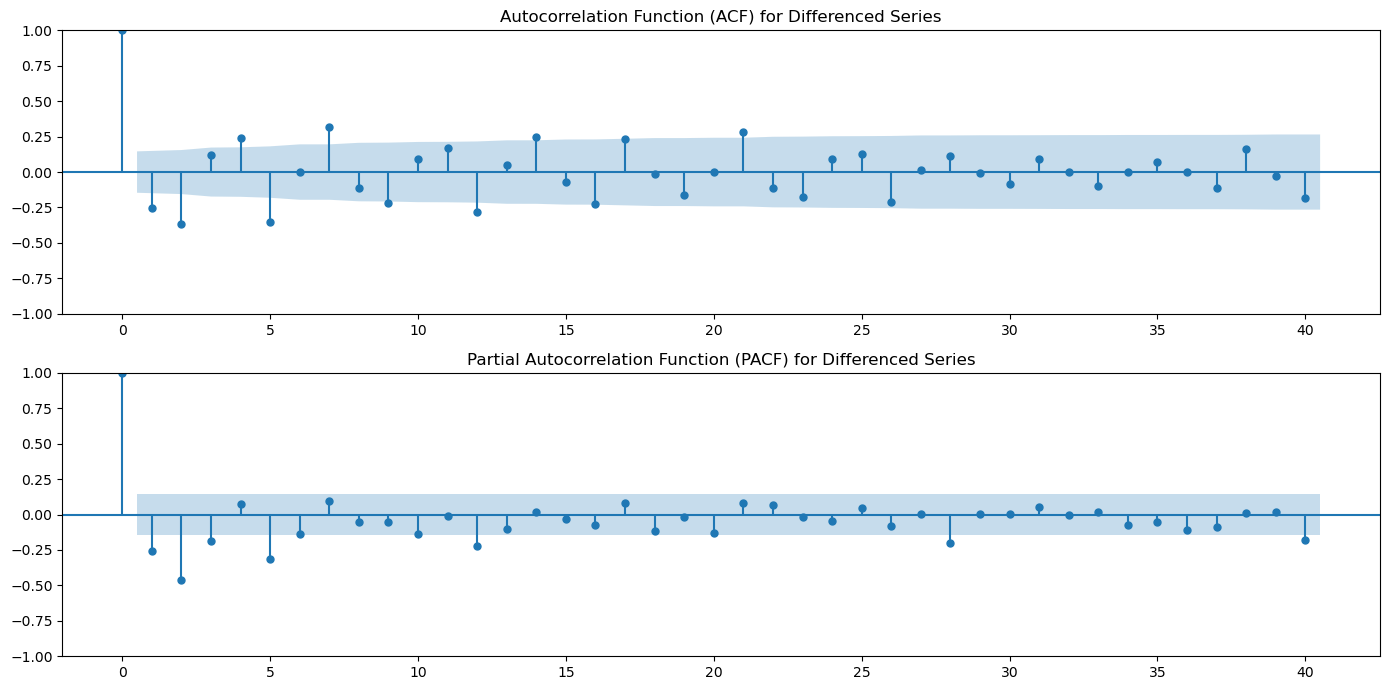

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original series and differenced series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF) for Differenced Series')

plt.subplot(2, 1, 2)
plot_pacf(data_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) for Differenced Series')

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

model = ARIMA(train, order=(2, 0, 5))
model_fit = model.fit()
confidences = model_fit.get_prediction(start=0, end=len(train) - 1).conf_int()

c:\Users\kevin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


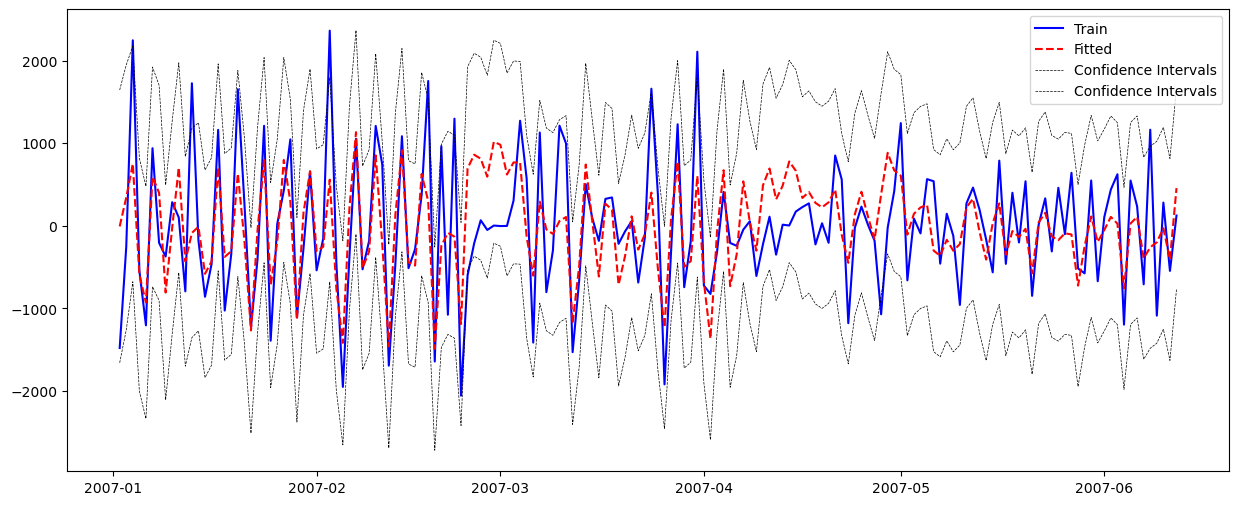

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(train, color='blue', label='Train')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted', linestyle='--')
plt.plot(confidences, color='black', linewidth=0.5, linestyle='--', label='Confidence Intervals')
plt.legend()
plt.show()

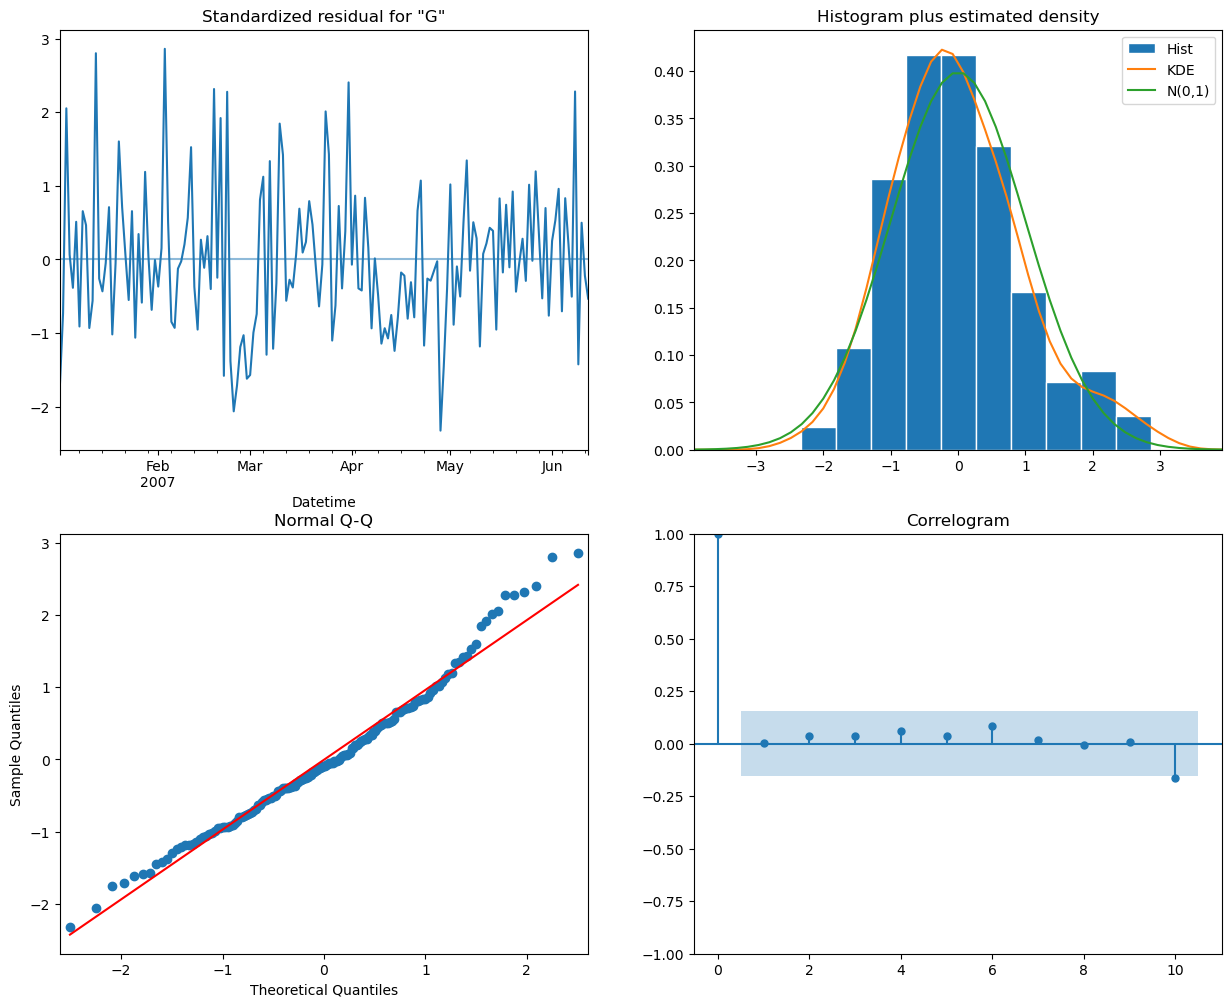

In [18]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [19]:
preds = []
true = []
conf_interv = []

for i in range(len(test)):
    model = ARIMA(train.values, order=(2, 0, 5))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    preds.append(forecast)
    true.append(test.iloc[i])
    train.loc[len(train)] = test.iloc[i]
    
    # Calculate the confidence interval
    conf_int = model_fit.get_forecast(steps=1).conf_int()
    conf_interv.append(conf_int)

c:\Users\kevin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kevin\AppData\Local\Temp\ipykernel_11800\1280600890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[len(train)] = test.iloc[i]
c:\Users\kevin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kevin\AppData\Local\Temp\ipykernel_11800\1280600890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

MAE: 309.7396 KWh


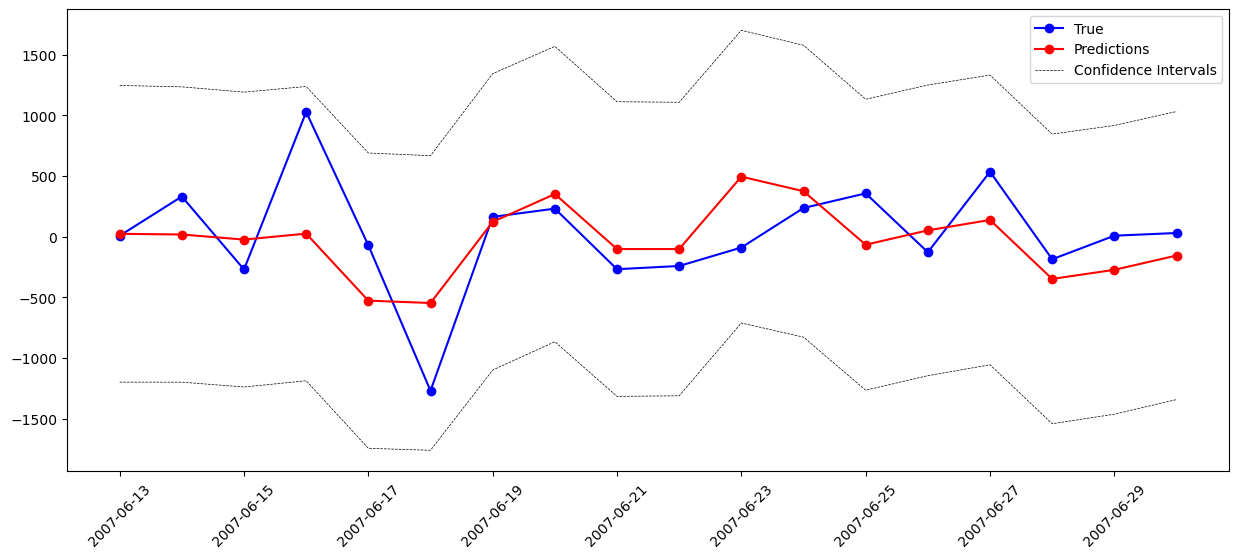

In [30]:
mae = mean_absolute_error(true, preds)
print(f'MAE: {mae:.4f} KWh')

plt.figure(figsize=(15, 6))
plt.plot(test.index, true, color='blue', label='True', marker='o')
plt.plot(test.index, preds, color='red', label='Predictions', marker='o')
plt.plot(test.index, [x[0][0] for x in conf_interv], color='black', linewidth=0.5, linestyle='--', label='Confidence Intervals')
plt.plot(test.index, [x[0][1] for x in conf_interv], color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()